In [1]:
setwd("..")

In [3]:
library(dplyr)
library(janitor)
library(purrr)
library(readr)
library(ggplot2)
library(tidyr)
library(ggpubr)
source("~/github/2022-microberna/scripts/utils.R")

## Obtain and read in GTDB rs207 metadata

In [4]:
destfile <- "inputs/gtdb-rs207/bac120_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-rs207/bac120_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

destfile <- "inputs/gtdb-rs207/ar53_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/ar53_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-r207/ar53_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

In [7]:
gtdb_metadata <- read_tsv("inputs/gtdb-rs207/bac120_metadata_r207.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession))

gtdb_metadata <- read_tsv("inputs/gtdb-rs207/ar53_metadata_r207.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession)) %>%
  bind_rows(gtdb_metadata)

Warning message:
“One or more parsing issues, see `problems()` for details”


## Read in charcoal results

In [8]:
charcoal <- Sys.glob("outputs/gtdb_rs207_charcoal*_reps/stage1_hitlist.csv") %>%
  map_dfr(read_csv, show_col_types = F) %>%
  mutate(genome = gsub("_genomic.fna.gz", "", genome))

In [13]:
gtdb_metadata <- gtdb_metadata %>%
  mutate(order_lineage = paste(sep = ";", domain, phylum, class, order))

combined <- left_join(charcoal, gtdb_metadata, by = c("genome" = "accession")) %>%
  mutate(lineages_match = ifelse(lineage == order_lineage, T, F),
         charcoal_contamination_order = (order_bad_bp/genome_size)*100,
         charcoal_contamination_family = (family_bad_bp/genome_size)*100,
         charcoal_contamination_genus = (genus_bad_bp/genome_size)*100,
         contaminated_at_filter_rank = ifelse(order_bad_bp > 0, T, F),
         contaminated_with_checkm = ifelse(checkm_contamination > 0, T, F))

## presence/absence of contamination with checkm or charcoal

if a genome is predicted to be contaminated with checkm, it is also contaminated with charcoal?

In [14]:
table(combined$contaminated_at_filter_rank, combined$contaminated_with_checkm)

       
        FALSE  TRUE
  FALSE  8861 27987
  TRUE   1110 12107

## how many genomes were contaminated?

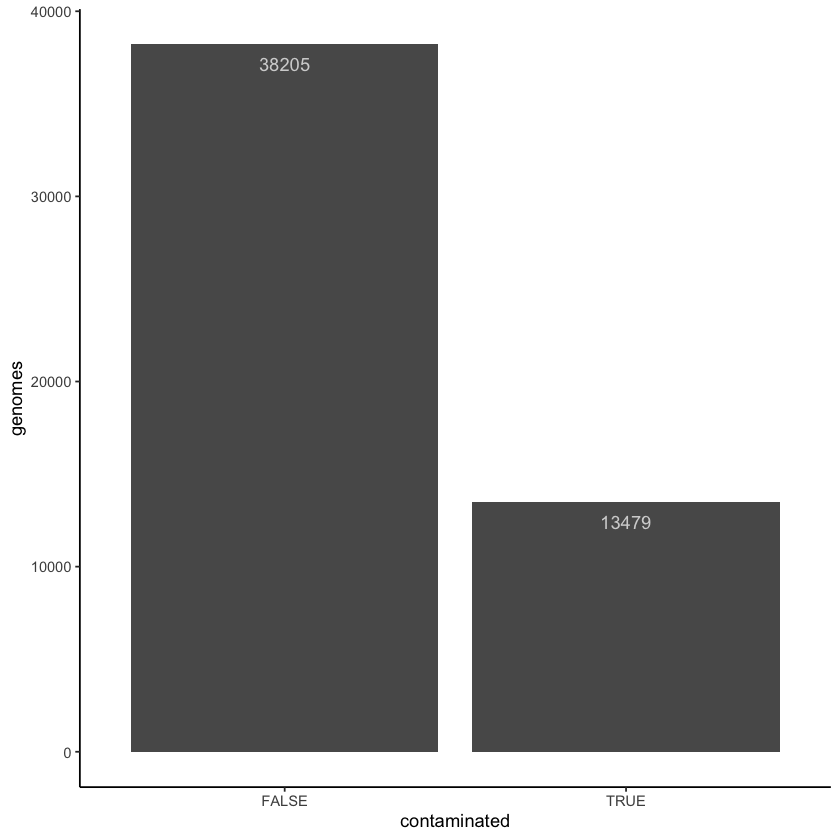

In [15]:
ggplot(combined, aes(x = contaminated_at_filter_rank, label = stat(count))) +
  geom_bar() +
  geom_text(stat = 'count', vjust = 2, color = "lightgrey") +
  theme_classic() +
  labs(y = "genomes", x = "contaminated")

In [16]:
13479/(38205+13479)

[1] 0.2607964

## how many refseq genomes were contaminated?

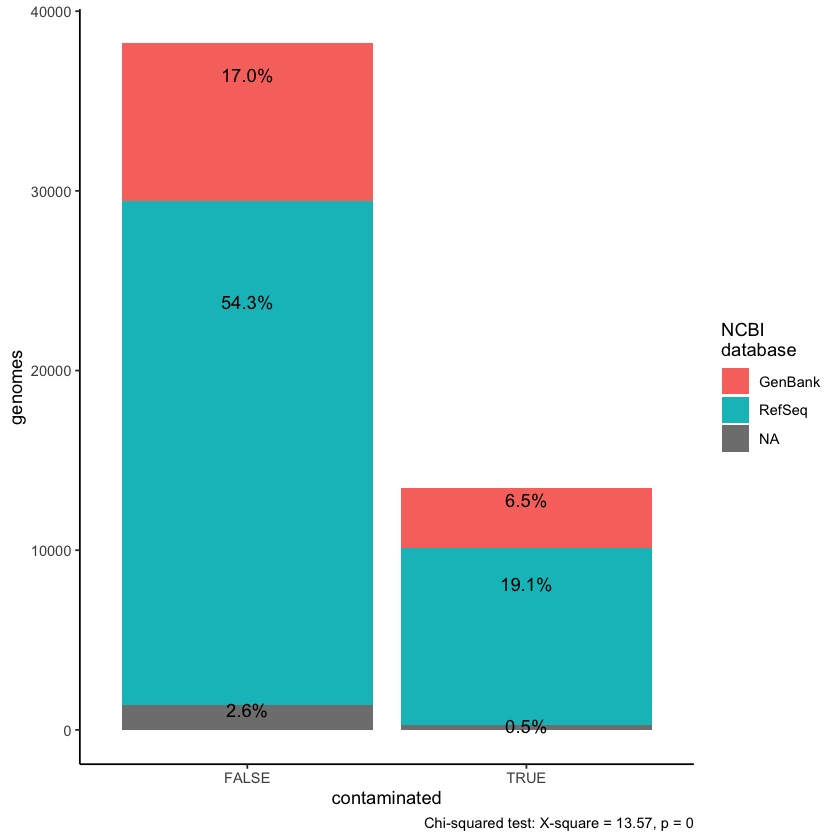

In [18]:
chi_sq_ncbi_db <- combined %>% 
  group_by(contaminated_at_filter_rank) %>% 
  ungroup %>%
  summarise(pval = chisq.test(contaminated_at_filter_rank, ncbi_database)$p.value,
            x_squared = chisq.test(contaminated_at_filter_rank, ncbi_database)$statistic)

ggplot(combined, aes(x = contaminated_at_filter_rank, fill = ncbi_database,
                     label = scales::percent(prop.table(stat(count))))) +
  geom_bar() +
  geom_text(stat = 'count',
            position = position_stack(.8)) +
  theme_classic() +
  labs(y = "genomes", x = "contaminated", fill = "NCBI\ndatabase",
    caption = paste0("Chi-squared test: X-square = ", 
                        round(chi_sq_ncbi_db$x_squared, digits =2), 
                        ", p = ", round(chi_sq_ncbi_db$pval,digits = 3)))

In [21]:
head(combined[is.na(combined$ncbi_database), ])
nrow(combined[is.na(combined$ncbi_database), ])

genome,filter_at,override_filter_at,total_bad_bp,superkingdom_bad_bp,phylum_bad_bp,class_bad_bp,order_bad_bp,family_bad_bp,genus_bad_bp,⋯,trna_count,trna_selenocysteine_count,ncbi_database,order_lineage,lineages_match,charcoal_contamination_order,charcoal_contamination_family,charcoal_contamination_genus,contaminated_at_filter_rank,contaminated_with_checkm
<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
GCF_003463705.1,order,NA,113944,0,51568,51568,113944,6575517,6575517,⋯,NA,NA,NA,NA,NA,NA,NA,NA,TRUE,NA
GCF_009678765.1,order,NA,87299,0,79331,79331,87299,3488753,3488753,⋯,NA,NA,NA,NA,NA,NA,NA,NA,TRUE,NA
GCF_003469815.1,order,NA,77088,0,77088,77088,77088,2258169,2258169,⋯,NA,NA,NA,NA,NA,NA,NA,NA,TRUE,NA
GCF_014306415.1,order,NA,72619,0,0,0,72619,2744748,2744748,⋯,NA,NA,NA,NA,NA,NA,NA,NA,TRUE,NA
GCA_902647025.1,order,NA,50951,0,0,0,50951,1181793,1181793,⋯,NA,NA,NA,NA,NA,NA,NA,NA,TRUE,NA
GCF_900472975.1,order,NA,36136,0,0,0,36136,6621804,6621804,⋯,NA,NA,NA,NA,NA,NA,NA,NA,TRUE,NA


[1] 1619

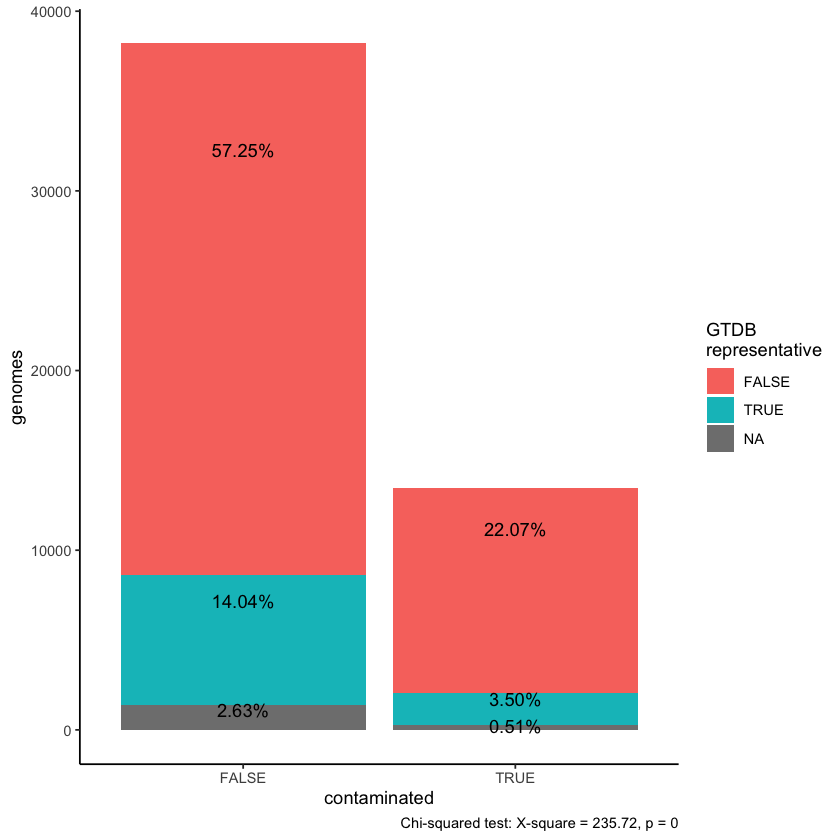

In [17]:
chi_sq_gtdb_rep <- combined %>% 
  group_by(contaminated_at_filter_rank) %>% 
  ungroup %>%
  summarise(pval = chisq.test(contaminated_at_filter_rank, gtdb_representative)$p.value,
            x_squared = chisq.test(contaminated_at_filter_rank, gtdb_representative)$statistic)

ggplot(combined, aes(x = contaminated_at_filter_rank, fill = gtdb_representative,
                     label = scales::percent(prop.table(stat(count))))) +
  geom_bar() + 
  theme_classic() +
  geom_text(stat = 'count',
            position = position_stack(.8)) +
  labs(y = "genomes", x = "contaminated", fill = "GTDB\nrepresentative",
    caption = paste0("Chi-squared test: X-square = ", 
                        round(chi_sq_gtdb_rep$x_squared, digits =2), 
                        ", p = ", round(chi_sq_gtdb_rep$pval,digits = 3)))